<a href="https://colab.research.google.com/github/keertanavc/course_allocation_code/blob/main/Course_Allocation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

MODIFIED ACEEI MECHANISM TO MINIMIZE COURSE ALLOCATION ERROR

PSEUDOCODE:
```
Inputs: 
dimension (d)
number of simulations with new generating vectors (N=30)
number of lattice points per simulation (L=50) 
```
```
For every n in [N]
  Generate set G = m change-in-demand vectors (m<=d) 
  (Let Z = zonotope defined by generating vectors G)
  Generate vertices of Z
  For every l in [L]
    Generate a lattice point pt inside Z
    Find the error of pt through both algorithms, store result
``` 

NOTES:
1. Maximum dimension limited because of complexity and computational constrains (exponential growth).
2. Exhaustive search is too expensive - repeated randomized simulation used instead.
3. Interested quantities: over-subscription error, market clearing error, % points with over-subscription error.

SIMULATION:

In [ ]:
#!pip install ortools==8.0.0

ERROR: Could not find a version that satisfies the requirement ortools==8.0.0 (from versions: 6.8.5452, 6.9.5822, 6.9.5824, 6.10.6025, 7.0b6150, 7.0.6546, 7.1.6720, 7.2.6977, 7.3.7083, 7.4.7247, 7.5.7466, 7.6.7691, 7.7.7810, 7.8.7959, 8.0.8283, 8.1.8487, 8.2.8710, 9.0.9048)
ERROR: No matching distribution found for ortools==8.0.0


In [ ]:
!pip install ortools==7.8.7959
import random
import numpy as np
import itertools
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from ortools.linear_solver import pywraplp
import pandas as pd

In [ ]:
# HELPER FUNCTIONS
def del_demand(d, m):
  '''
  Function that generates m change-in-demand
  vectors of dimension d 
  '''
  G = []
  i = 0
  while i < m:
    v = [random.choice([-1,0,1]) for i in range(d)]
    if v not in G:
      G.append(v)
      i += 1
  G = [np.array(i) for i in G]
  return G

def gen_vertices(G, m):
  '''
  Function to compute zonotope vertices from 
  generting vectors (of dimension m) in G 
  '''
  vlmbda_lst = [np.array(seq) for seq in itertools.product([0,1], repeat=m)]
  vertex_lst = []
  for vlmbda in vlmbda_lst:
    V = np.array([a*b for a,b in zip(G, vlmbda)])
    vertex = np.sum(V, axis=0)
    vertex_lst.append(vertex)
  return vertex_lst

def gen_point(G, d, m):
  '''
  Function to generate a lattice point in the zonotope
  with G generating vectors of dimention d and V vertices
  '''
  Gnew = np.array(G)
  while 1:
    Gnew = np.array(G, np.float)
    linit = np.array([random.uniform(0,1) for i in range(m)])
    for i in range(m):
      Gnew[i,:] = np.array(Gnew[i,:] * linit[i])
    pt = np.sum(Gnew, axis=0)
    pt = [np.round(i) for i in pt]

    # Define solver
    solver = pywraplp.Solver.CreateSolver('simple_lp_program', 'GLOP')
    # Define variables
    lmbdas = [solver.NumVar(0, 1, 'lmbda'+str(i)) for i in range(m)]

    # Define constraints
    Gnew = np.array(G, np.float)
    for i in range(d):
      ct = solver.Constraint(float(pt[i]), float(pt[i]), 'ct'+str(i))
      for j in range(m):
        ct.SetCoefficient(lmbdas[j], float(Gnew[j,i]))

    # Define objective
    objective = solver.Objective()
    for i in range(m):
      objective.SetCoefficient(lmbdas[i], 1)
    objective.SetMaximization()

    status = solver.Solve()

    # Check convergence
    if status == solver.OPTIMAL:
      sol = [l.solution_value() for l in lmbdas]
      break
  return np.array(pt), sol

def find_err(pt, V):
  '''
  Given a point pt in zonotope with vertices V,
  finds the market clearing and over subscription 
  errors based on old and new algorithms
  '''
  mcold, mcnew, osold, osnew = [10**3] * 4
  for v in V:
    mcvec = v-pt
    mcerr = np.linalg.norm(mcvec) 
    osvec = (mcvec > 0) * mcvec 
    oserr = np.linalg.norm(osvec)
    # Condition for old algo - min market clearing
    if mcold >= mcerr:
      if mcold == mcerr:
        osold = max(osold, oserr)
      else:
        mcold = mcerr
        osold = oserr
    # Condition for new algo - min over subscription
    if osnew >= oserr:
      if osnew == oserr:
        mcnew = min(mcnew, mcerr)
      else:
        osnew = oserr
        mcnew = mcerr
  return (mcold, osold, mcnew, osnew)

def generate_ub(sigma, d):
  '''
  Function generates upper bound on error
  for both the algorithms
  '''
  mcoldub = ((sigma*d)**0.5) / 2
  mcnewub = ((sigma*d)**0.5)
  osoldub = ((sigma*d)**0.5) / 2
  osnewub = ((sigma*(d-2))**0.5) / 2

  return mcoldub, mcnewub, osoldub, osnewub

In [ ]:
random.seed(20)
# INPUTS
max_d = 14
N = 20
L = 250

# Metrics
avg_mc_old = []
avg_mc_new = []
avg_os_old = []
avg_os_new = []
per_inc_mc = []
per_dec_os = []
per_pos_os_new = []
per_pos_os_old = []
dim = []

for d in range(2, max_d+1):
  print(d)

  for i in range(N):
    # Construct Zonotope
    #m = random.randint(2, d)
    m = d
    G = del_demand(d, m)
    V = gen_vertices(G, m)

    err_os_old_lst = []
    err_os_new_lst = []
    err_old_lst = []
    err_new_lst = []

    # Run algorithm
    for j in range(L):
      pt, lmbda = gen_point(G, d, m)
      mcold, osold, mcnew, osnew = find_err(pt, V)
 
      err_os_old_lst.append(osold)
      err_os_new_lst.append(osnew)
      err_old_lst.append(mcold)
      err_new_lst.append(mcnew)

    err_os_old_lst = np.array(err_os_old_lst)
    err_os_new_lst = np.array(err_os_new_lst)
    err_old_lst = np.array(err_old_lst)
    err_new_lst = np.array(err_new_lst)
    
    avg_mc_old.append([d, np.mean(err_old_lst)])
    avg_mc_new.append([d, np.mean(err_new_lst)])
    avg_os_old.append([d, np.mean(err_os_old_lst)])
    avg_os_new.append([d, np.mean(err_os_new_lst)])

    # Sanity checks
    if all((err_os_old_lst) >= (err_os_new_lst)) is False:
      print('Over subscription calculation error!')
    if all((err_new_lst) >= (err_old_lst)) is False:
      print('Market clearing error calculation error!')

    # Upper bound checks
    k = d
    sigma = max(2*k,d)
    mcoldub, mcnewub, osoldub, osnewub = generate_ub(sigma, d)
    if all(err_old_lst<=mcoldub) is False:
      print('old market clearing exceeds bound')
    if all(err_new_lst<=mcnewub) is False:
      print('new market clearing exceeds bound')
    if all(err_os_old_lst<=osoldub) is False:
      print('old over subscription exceeds bound')
    if all(err_os_new_lst<=osnewub) is False:
      print('new over subscription exceeds bound')


    inc_mc = (np.mean(err_new_lst-err_old_lst))/np.mean(err_old_lst)*100
    dec_os = (np.mean(err_os_old_lst-err_os_new_lst))/np.mean(err_os_old_lst)*100
    os_old = np.sum(err_os_old_lst>0)/len(err_os_old_lst)*100
    os_new = np.sum(err_os_new_lst>0)/len(err_os_new_lst)*100

    per_inc_mc.append(inc_mc)
    per_dec_os.append(dec_os)
    per_pos_os_old.append(os_old)
    per_pos_os_new.append(os_new)
    dim.append(d)

2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in double_scalars


3
4
5
6
7
8
9
10
11
12
13
14


RESULTS:

In [ ]:
data = pd.DataFrame([dim, per_inc_mc, per_dec_os, per_pos_os_old, per_pos_os_new]).T
data.columns = ['dim', 'per_inc_mc', 'per_dec_os', 'per_pos_os_old', 'per_pos_os_new']

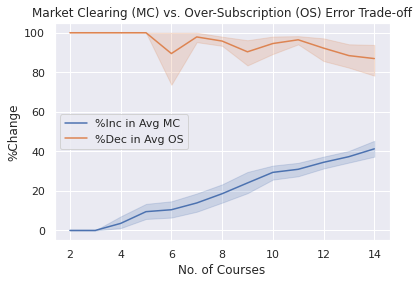

In [ ]:
ax = sns.lineplot(x='dim', y='per_inc_mc', data=data, label='%Inc in Avg MC')
ax = sns.lineplot(x='dim', y='per_dec_os', data=data, label='%Dec in Avg OS')
ax.set_title('Market Clearing (MC) vs. Over-Subscription (OS) Error Trade-off')
ax.set_ylabel('%Change')
ax.set_xlabel('No. of Courses')
ax.legend(loc='center left')
plt.show()

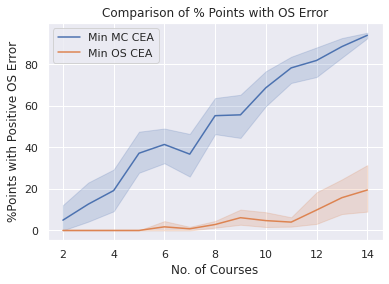

In [ ]:
ax = sns.lineplot(x='dim', y='per_pos_os_old', data=data, label='Min MC CEA')
ax = sns.lineplot(x='dim', y='per_pos_os_new', data=data, label='Min OS CEA')
ax.set_title('Comparison of % Points with OS Error')
ax.set_ylabel('%Points with Positive OS Error')
ax.set_xlabel('No. of Courses')
ax.legend(loc='upper left')
plt.show()

In [ ]:
data.std()

dim                3.748874
per_inc_mc        14.793880
per_dec_os        14.509175
per_pos_os_old    34.097540
per_pos_os_new    12.684776
dtype: float64

In [ ]:
data2 = pd.DataFrame(avg_mc_old)
data2.columns = ['dim', 'avg_mc_old']
data2['avg_mc_new'] = pd.DataFrame(avg_mc_new)[1]
data2['avg_os_old'] = pd.DataFrame(avg_os_old)[1]
data2['avg_os_new'] = pd.DataFrame(avg_os_new)[1]

In [ ]:
data2.columns

Index(['dim', 'avg_mc_old', 'avg_mc_new', 'avg_os_old', 'avg_os_new'], dtype='object')

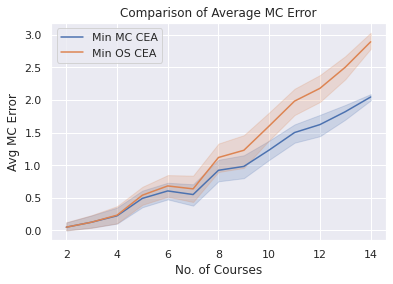

In [ ]:
ax = sns.lineplot(x='dim', y='avg_mc_old', data=data2, label='Min MC CEA')
ax = sns.lineplot(x='dim', y='avg_mc_new', data=data2, label='Min OS CEA')
ax.set_title('Comparison of Average MC Error')
ax.set_ylabel('Avg MC Error')
ax.set_xlabel('No. of Courses')
ax.legend(loc='upper left')
plt.show()

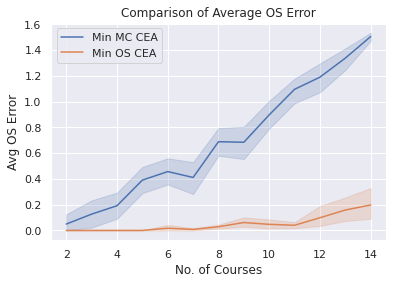

In [ ]:
ax = sns.lineplot(x='dim', y='avg_os_old', data=data2, label='Min MC CEA')
ax = sns.lineplot(x='dim', y='avg_os_new', data=data2, label='Min OS CEA')
ax.set_title('Comparison of Average OS Error')
ax.set_ylabel('Avg OS Error')
ax.set_xlabel('No. of Courses')
ax.legend(loc='upper left')
plt.show()

In [ ]:
1

1